0.13776788576088617
671.7125702165552
17.149556867053022


<AxesSubplot:>

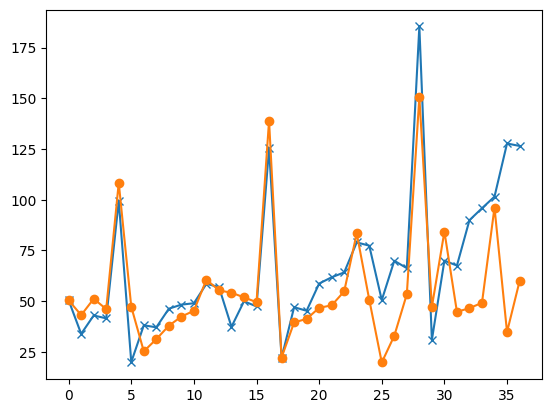

In [39]:

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from pmdarima import auto_arima



file_path = './source_data/A1backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
# data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=StandardScaler()
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    # print(train)
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled


train_num = 80
scaler, train_data,test_data = scale(diff_data[0][:train_num].to_numpy().reshape(-1,1),diff_data[0][train_num:].to_numpy().reshape(-1,1))


train_data = pd.DataFrame(train_data)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']



model = auto_arima(train_data[44:], seasonal=True, m=12)
test_predict = model.predict(test_data.shape[0])


test_predict.index = test_data.index


test_predict = scaler.inverse_transform(test_predict.to_numpy().reshape(-1,1)).reshape(-1)
# test_predict

test_data = scaler.inverse_transform(test_data).reshape(-1)
train_data = scaler.inverse_transform(train_data)

# # test_predict.plot(marker='x')

def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

train_data.sum()

inverse_predict =  inverse_difference(train_data.sum()+data['sales'][0],test_predict)
inverse_predict = inverse_predict.apply(np.expm1)
# # # inverse_predict


inverse_test = inverse_difference(train_data.sum()+data['sales'][0],test_data)
inverse_test = inverse_test.apply(np.expm1)



print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))
print(mean_absolute_error(inverse_test[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_test[0].plot(marker='o')